# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import datetime
import os
import random as rn
from keras import backend as K
import tensorflow as tf

# seting the random seed so that the results don't vary drastically.
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)
#tf.set_random_seed(30)

Using TensorFlow backend.


---

## Reading Dataset

- Dataset contains a `train` and a `val` folder with two CSV files for the two folders.
- These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Each subfolder, i.e. a video, contains 30 frames (or images).
- <b>Note:</b> that all images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160.

In [2]:
# define the path where training and validation data are placed.
SOURCE_PATH = os.getcwd()

# Training data constants
TRAIN_DATA_PATH = SOURCE_PATH + '/Project_data/train'
TRAIN_DATA_CSV = SOURCE_PATH + '/Project_data/train.csv'

# Validation data constants
VALIDATION_DATA_PATH = SOURCE_PATH + '/Project_data/val'
VALIDATION_DATA_CSV = SOURCE_PATH + '/Project_data/val.csv'

Below block, we read the folder names for training and validation.

In [3]:
TRAIN_DOC = np.random.permutation(open(TRAIN_DATA_CSV).readlines())
VALIDATION_DOC = np.random.permutation(open(VALIDATION_DATA_CSV).readlines())

print("Training data size = {}".format(len(TRAIN_DOC)))
print("Validation data size = {}".format(len(VALIDATION_DOC)))

Training data size = 663
Validation data size = 100


---
### Standardise Video Frame Dimension:

- Input to Neural Network should always be same otherwise network will throw exception.
- As Videos has two types of dimension -either `360x360` or `120x160`. We have to standardise the input videos frames.
- Lets first visualize `360x360` and `120x160` image in different dimension as below:
    - `256x256`
    - `128x128`

In [4]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images))
    f.set_figwidth(15)
    for ax,image,caption in zip(axes, images, captions):
        ax.imshow(image, cmap)
        ax.set_title(caption)

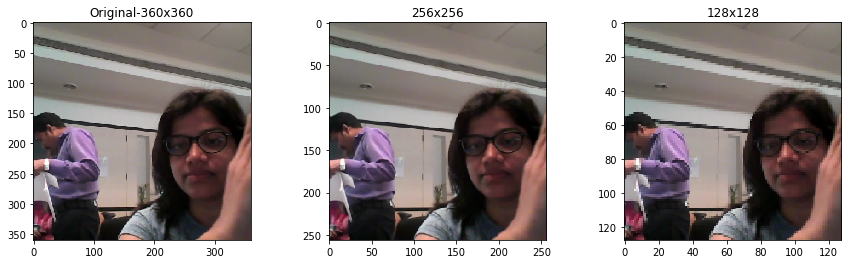

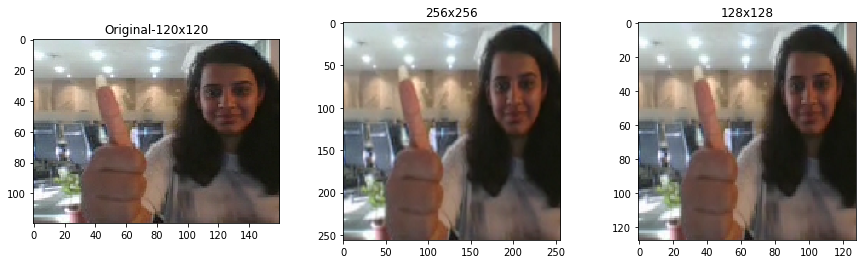

In [5]:
# Below is the example of frames with different dimension.

# below is 360x360 image frame
largeSizeImage = cv2.cvtColor(
    cv2.imread(
        TRAIN_DATA_PATH + '/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png'),
    cv2.COLOR_BGR2RGB)


# below is 120x160 image frame
smallSizeImage = cv2.cvtColor(
    cv2.imread(
        TRAIN_DATA_PATH + '/WIN_20180925_17_22_11_Pro_Thumbs_Up_new/WIN_20180925_17_22_11_Pro_00041.png'),
    cv2.COLOR_BGR2RGB)


# resize of 360x360 image and plot
largeSizeImageResizeTo128 = cv2.resize(largeSizeImage, (128, 128))
largeSizeImageResizeTo256 = cv2.resize(largeSizeImage, (256, 256))
plot_image([largeSizeImage, largeSizeImageResizeTo256, largeSizeImageResizeTo128],
           captions = ["Original-360x360", "256x256", "128x128" ])


# resize of 120x160 image and plot
smallSizeImageResizeTo128 = cv2.resize(smallSizeImage, (128, 128))
smallSizeImageResizeTo256 = cv2.resize(smallSizeImage, (256, 256))
plot_image([smallSizeImage, smallSizeImageResizeTo256, smallSizeImageResizeTo128  ],
           captions = ["Original-120x120", "256x256", "128x128" , ])


- We can choose any one of these dimenstion for Training Deep learning Neural Network.

<b>Note:<br/>
We have observed that by keeping higher dimension image, Network is throwing `ResourceExhaustedError: OOM` exception.<br/>
Hence we are choosing `128x128` as standard dimension for training.</b><br/>

---

### Possible Videos Frames Augmentations:
`Flipping`: `No`
- Up-down flip of frame will not be helpful
- Left-Right flip incase of fast forward or backward will consfuse the model


`Rotation` : `No`
- Rotating to certain angle is quite possible, but we would prefer no to use as data would already have certain degree of rotation.

`Cropping` : `Yes`
- We will using this for cropping the image to common dimenstion(`120x120`) and can be feeded to model.

`Scaling` : `Yes`
- We are using this for resizing the image to common dimenstion(`128x128`) and can be feeded to model.

`Translation` : `No`
- With given problem statement, translating the frames may break the sequence of action which model actually needs to learn. 

In [6]:
"""
Class is the wrapper class which can perform resize of frame to 128x128 and cropping frame to 120x120
"""

class FrameProcessing():
    
    def __init__(self, path):
        """
            When the image file is read with the OpenCV function imread(), the order of colors is BGR.
            Hence changing it to RGB
        """
        self.image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    
    def get(self):
        """get the image array"""
        return self.image
    
    def resize(self):
        """ resize the image to 128x128 """
        self.image = cv2.resize(self.image, (128,128), interpolation=cv2.INTER_AREA)
        return self
    
    def crop (self):
        """crop the image to 120x120"""
        self.image = self.image[4:124, 4:124]
        return self;
    
    def normalization(self):
        """normalize the image by dividing by 255"""
        self.image = self.image/255
        return self
        

Below is resizes frame to 128x128:


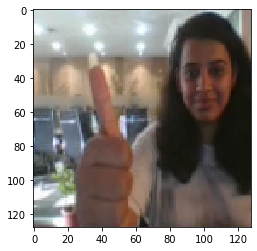

In [7]:
# Unit testing on FrameProcessing class.

# standardise image 128x128
img = FrameProcessing(
    TRAIN_DATA_PATH + '/WIN_20180925_17_22_11_Pro_Thumbs_Up_new/WIN_20180925_17_22_11_Pro_00041.png').resize()

print("Below is resizes frame to 128x128:")
plt.imshow(img.get())

Below is crop frame to 120x120:


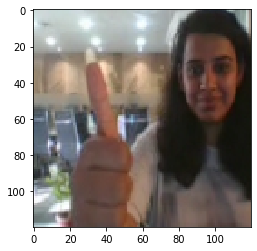

In [8]:
print("Below is crop frame to 120x120:")
# cropped image 120x120
plt.imshow(img.crop().get())

In [9]:
# each video of 30 frames
VIDEO_FRAME_COUNT = 30

# Instead of taking 30 frames, we would be trying to build model with 15 frames and evaluate
VIDEO_SKIP_FRAME_COUNT = 15

# Class type to classify are 5
# 1. Thumbs up:  Increase the volume
# 2. Thumbs down: Decrease the volume
# 3. Left swipe: 'Jump' backwards 10 seconds
# 4. Right swipe: 'Jump' forward 10 seconds  
# 5. Stop: Pause the movie
CLASS_COUNT = 5

# Standardise dimenstion
FRAME_RESIZE_DIMENSION = (128, 128)

# Let use crop dimenstion by reducing 10 pixel from edges
FRAME_RESIZE_CROP_DIMENSION = (120, 120)

In [10]:
# get current timestamp
curr_dt_time = datetime.datetime.now()

# number to total training sequence
num_train_sequences = len(TRAIN_DOC)
print('Training sequences =', num_train_sequences)

# number to total validation sequence
num_val_sequences = len(VALIDATION_DOC)
print('Validation sequences =', num_val_sequences)

# number of epochs
num_epochs= 20
print ('epochs =', num_epochs)

Training sequences = 663
Validation sequences = 100
epochs = 20


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [11]:
def generator(source_path, folder_list, batch_size, crop=False, skipFrames=False):
    if (skipFrames == True):
        # taking frames like 0,2,4,6....28
        img_idx = list(range(0, VIDEO_FRAME_COUNT, 2))
    else:
        # reading index of images from 0 to 29
        img_idx = list(range(0, VIDEO_FRAME_COUNT, 1))

    while True:
        t = np.random.permutation(folder_list)

        # number to batches
        num_batches = len(t)//batch_size
        for batch in range(num_batches):
            # incase of crop is required, batch_data will change with respect to frame pixel dimension
            if crop == True:
                # frame 120x120
                batch_data = np.zeros((batch_size,
                                       len(img_idx),FRAME_RESIZE_CROP_DIMENSION[0],FRAME_RESIZE_CROP_DIMENSION[1],3))
            else:
                # frame 128x128
                batch_data = np.zeros((batch_size,
                                       len(img_idx),FRAME_RESIZE_DIMENSION[0],FRAME_RESIZE_DIMENSION[1],3))

            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):                    
                    imageObj = FrameProcessing(
                        source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])

                    # just performing resize to 128x128
                    imageObj.resize()
                    # perform crop to 120x120 is crop input variable is True
                    if crop == True:
                        imageObj.crop()
                    
                    # noralize the image by dividing by 255
                    imageObj.normalization()
                    
                    batch_data[folder,idx,:,:,0] = imageObj.get()[:,:,0]
                    batch_data[folder,idx,:,:,1] = imageObj.get()[:,:,1]
                    batch_data[folder,idx,:,:,2] = imageObj.get()[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels 

        
        # remaining data points which are left after full batches
        remaining_folder = len(t)%batch_size
        if (remaining_folder > 0):
            # incase of crop is required, batch_data will change with respect to frame pixel dimension
            if crop == True:
                # frame 120x120
                batch_data = np.zeros((remaining_folder,
                                       len(img_idx),FRAME_RESIZE_CROP_DIMENSION[0],FRAME_RESIZE_CROP_DIMENSION[1],3))
            else:
                # frame 128x128
                batch_data = np.zeros((remaining_folder,
                                       len(img_idx),FRAME_RESIZE_DIMENSION[0],FRAME_RESIZE_DIMENSION[1],3))
            
            batch_labels = np.zeros((remaining_folder,5))
            for folder in range(0, remaining_folder):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    imageObj = FrameProcessing(
                        source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])

                    # just performing resize as discussed above
                    imageObj.resize()
                    # perform crop to 120x120 is crop input variable is True
                    if crop == True:
                        imageObj.crop()
                    
                    # noralize the image by dividing by 255
                    imageObj.normalization()

                    batch_data[folder,idx,:,:,0] = imageObj.get()[:,:,0]
                    batch_data[folder,idx,:,:,1] = imageObj.get()[:,:,1]
                    batch_data[folder,idx,:,:,2] = imageObj.get()[:,:,2]
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            
            yield batch_data, batch_labels



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

---
# Model

### Importing Libraries

In [12]:
# Import required libraries
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, Dropout, TimeDistributed, Flatten, BatchNormalization, Activation, GlobalAveragePooling3D
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.mobilenetv2 import MobileNetV2


### Common functions:

In [13]:
""" Method to get required callbacks like Checkpoint and Reduce Learning Rate"""
def model_callbacks(model_checkpoint_name):
    # model_name = model_checkpoint_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    model_folder = "models/"
    if not os.path.exists(model_folder):
        os.mkdir(model_folder)

    filepath = model_folder +  model_checkpoint_name + '-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    # Checkpoint will be created only when val_categorical_accuracy is higher than previous epoch step.
    checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max', period=1)

    # defining the Reduce LR to avoid Plateau
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=2)
    callbacks_list = [checkpoint, LR]
    return callbacks_list



"""Method to plot Models loss and accurarcy"""
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    

""" Method return steps required per epoch based on batch_size"""
def getStepsPerEpoch(batch_size):
    # steps required in each epoch
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1
    return steps_per_epoch

""" Method return validation steps based on batch_size"""
def getValidationSteps(batch_size):
    # number of validation steps required in model validation
    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return validation_steps


""" Main method to return training generator, validation generatory, steps per epoch and validation steps"""
def getConfig(train_path, train_doc, validation_path, validation_doc, batch_size, crop=False, skipFrames=False):
    train_generator = generator(train_path, train_doc, batch_size, crop, skipFrames)
    val_generator = generator(validation_path, validation_doc, batch_size, crop, skipFrames)
    steps_per_epoch = getStepsPerEpoch(batch_size)
    validation_steps = getValidationSteps(batch_size)
    return train_generator, val_generator, steps_per_epoch, validation_steps
    
    

---

# Conv3D Models

## `Conv3D` : Basic Models with Frame resize to 128x128:

The Above generator function support resize of image to `128x128` by default. In the below experiment we would be trying to build basic model with different convolution filter sizes. Typically filter sizes as below:
- Filter size (2, 2, 2)
- Filter size (3, 3, 3)

### `Conv3D` Basic model with filter size (2, 2, 2)

- We would be trying to build a basic convolution model (filter size = (2, 2, 2)).
- No optimization technique being used like Batch Normalization, Dropouts.

In [14]:
def Conv3DWithFilter2_2_2():
    model = Sequential()
    model.add(Conv3D(32, (2, 2, 2), padding='same',
                         input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(CLASS_COUNT, activation='softmax'))

    optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

# Initialize the model
Conv3DModelWithFilter2_2_2 = Conv3DWithFilter2_2_2()

# Summary of the model
Conv3DModelWithFilter2_2_2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 128, 128, 32)  800       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 128, 128, 32)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 64, 64, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 64, 64, 64)    16448     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 64, 64, 64)    0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 32, 32, 64)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 32, 32, 64)    

Epoch 1/20
27/27 [==============================] - 57s 2s/step - loss: 1.3789 - categorical_accuracy: 0.4037 - val_loss: 1.5838 - val_categorical_accuracy: 0.3200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.32000, saving model to models/Conv3DModelWithFilter2_2_2-00001-1.38272-0.40271-1.58385-0.32000.h5
Epoch 2/20
27/27 [==============================] - 47s 2s/step - loss: 1.0145 - categorical_accuracy: 0.6047 - val_loss: 1.8313 - val_categorical_accuracy: 0.2900

Epoch 00002: val_categorical_accuracy did not improve from 0.32000
Epoch 3/20
27/27 [==============================] - 51s 2s/step - loss: 0.8417 - categorical_accuracy: 0.7205 - val_loss: 1.4896 - val_categorical_accuracy: 0.4500

Epoch 00003: val_categorical_accuracy improved from 0.32000 to 0.45000, saving model to models/Conv3DModelWithFilter2_2_2-00003-0.83972-0.72097-1.48961-0.45000.h5
Epoch 4/20
27/27 [==============================] - 52s 2s/step - loss: 0.7320 - categorical_accuracy: 0.7633 - val

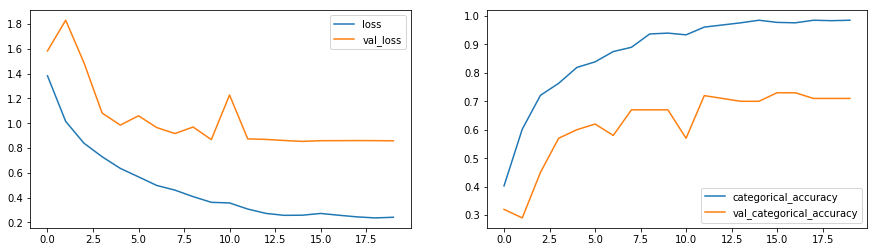

In [16]:
# Below is the maximum batch_size that can be used here. Determined this value after multiple runs.
BATCH_SIZE = 25


# get generator, steps per epochs and validation steps based on batch_size
train_generator, val_generator, steps_per_epoch, validation_steps = getConfig(
    TRAIN_DATA_PATH, TRAIN_DOC, VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE)


# build the basic Conv3D model with filter size (2, 2, 2)
history = Conv3DModelWithFilter2_2_2.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModelWithFilter2_2_2'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)


# plot loss and accuracy 
plot(history)

### Conv3D with filter size (3, 3, 3)

In [13]:
def Conv3DWithFilter3_3_3():
    model = Sequential()
    model.add(Conv3D(32, (3, 3, 3), padding='same',
                         input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(CLASS_COUNT, activation='softmax'))

    optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

Conv3DModelWithFilter3_3_3 = Conv3DWithFilter3_3_3()
    
Conv3DModelWithFilter3_3_3.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 128, 128, 32)  2624      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 128, 128, 32)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 64, 64, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 64, 64, 64)    55360     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 64, 64, 64)    0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 32, 32, 64)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 32, 32, 64)     110656    
__________

Epoch 1/20
27/27 [==============================] - 63s 2s/step - loss: 1.3775 - categorical_accuracy: 0.4006 - val_loss: 2.3483 - val_categorical_accuracy: 0.2800

Epoch 00001: val_categorical_accuracy improved from -inf to 0.28000, saving model to models/Conv3DModelWithFilter3_3_3-00001-1.38277-0.39819-2.34834-0.28000.h5
Epoch 2/20
27/27 [==============================] - 51s 2s/step - loss: 1.0564 - categorical_accuracy: 0.6108 - val_loss: 1.7452 - val_categorical_accuracy: 0.3400

Epoch 00002: val_categorical_accuracy improved from 0.28000 to 0.34000, saving model to models/Conv3DModelWithFilter3_3_3-00002-1.05423-0.60935-1.74515-0.34000.h5
Epoch 3/20
27/27 [==============================] - 54s 2s/step - loss: 0.9326 - categorical_accuracy: 0.6457 - val_loss: 1.2689 - val_categorical_accuracy: 0.5200

Epoch 00003: val_categorical_accuracy improved from 0.34000 to 0.52000, saving model to models/Conv3DModelWithFilter3_3_3-00003-0.92822-0.65158-1.26892-0.52000.h5
Epoch 4/20
27/27 [=

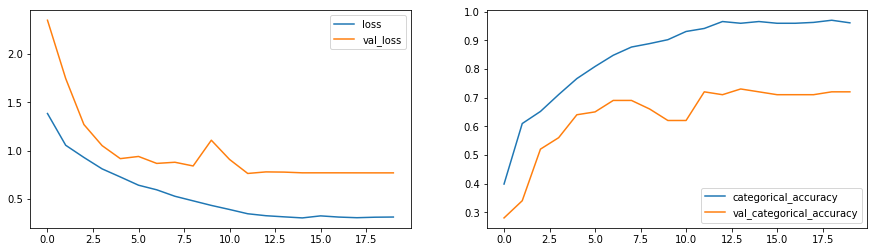

In [14]:
BATCH_SIZE = 25

train_generator, val_generator, steps_per_epoch, validation_steps = getConfig(
    TRAIN_DATA_PATH, TRAIN_DOC, VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE)

history = Conv3DModelWithFilter3_3_3.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModelWithFilter3_3_3'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

## Model: Conv3D Filter size(2,2,2) and Batch Normalization

- Model with filter size (2,2,2)
- This also includes Batch Normalization steps

In [13]:
def Conv3DWithFilter2_2_2_BN():
    model = Sequential()
    model.add(Conv3D(32, (2, 2, 2), padding='same',
                         input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(CLASS_COUNT, activation='softmax'))

    optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

Conv3DModelWithFilter2_2_2_BN = Conv3DWithFilter2_2_2_BN()
    
Conv3DModelWithFilter2_2_2_BN.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 128, 128, 32)  800       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 128, 128, 32)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 128, 128, 32)  128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 64, 64, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 64, 64, 64)    16448     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 64, 64, 64)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 64, 64, 64)    256       
__________

Epoch 1/20
34/34 [==============================] - 172s 5s/step - loss: 1.3177 - categorical_accuracy: 0.4753 - val_loss: 1.8871 - val_categorical_accuracy: 0.3500

Epoch 00001: val_categorical_accuracy improved from -inf to 0.35000, saving model to models/Conv3DModelWithFilter2_2_2_BN-00001-1.29419-0.48718-1.88711-0.35000.h5
Epoch 2/20
34/34 [==============================] - 62s 2s/step - loss: 0.5704 - categorical_accuracy: 0.8028 - val_loss: 1.1257 - val_categorical_accuracy: 0.5500

Epoch 00002: val_categorical_accuracy improved from 0.35000 to 0.55000, saving model to models/Conv3DModelWithFilter2_2_2_BN-00002-0.55468-0.81448-1.12572-0.55000.h5
Epoch 3/20
34/34 [==============================] - 63s 2s/step - loss: 0.3736 - categorical_accuracy: 0.8985 - val_loss: 0.9482 - val_categorical_accuracy: 0.6000

Epoch 00003: val_categorical_accuracy improved from 0.55000 to 0.60000, saving model to models/Conv3DModelWithFilter2_2_2_BN-00003-0.34835-0.91252-0.94818-0.60000.h5
Epoch 4/2

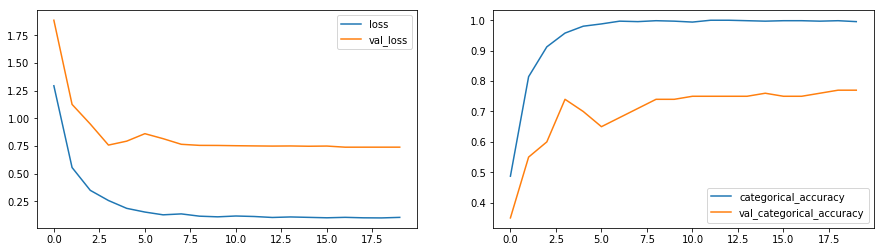

In [14]:
BATCH_SIZE = 20

train_generator, val_generator, steps_per_epoch, validation_steps = getConfig(
    TRAIN_DATA_PATH, TRAIN_DOC, VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE)

history = Conv3DModelWithFilter2_2_2_BN.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModelWithFilter2_2_2_BN'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

<b>Observations:</b>
> - This shows a complete overfit where Model on training dataset has a accuracy of ~100%.
> - Loss in Train and validation dataset is continously decreasing.
> - Validation dataset accurarcy is 74% after 20 epochs.

---
## Model: Conv3D with Filter size(3,3,3) and Batch Normalization

<b>Note: Idea here is to validate which filter size is doing well with respect to validation accuracy</b>

- Model with filter size (3,3,3)
- This also includes Batch Normalization steps

In [15]:
def Conv3DWithFilter3_3_3_BN():
    model = Sequential()
    model.add(Conv3D(32, (3, 3, 3), padding='same',
                         input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(CLASS_COUNT, activation='softmax'))

    optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model


# get model
Conv3DModelWithFilter3_3_3_BN = Conv3DWithFilter3_3_3_BN()

# model summary
Conv3DModelWithFilter3_3_3_BN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 128, 128, 32)  2624      
_________________________________________________________________
activation_4 (Activation)    (None, 30, 128, 128, 32)  0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 128, 128, 32)  128       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 64, 64, 32)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 64, 64, 64)    55360     
_________________________________________________________________
activation_5 (Activation)    (None, 15, 64, 64, 64)    0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 64, 64, 64)    256       
__________

Epoch 1/20
34/34 [==============================] - 72s 2s/step - loss: 1.2970 - categorical_accuracy: 0.4930 - val_loss: 3.5081 - val_categorical_accuracy: 0.2300

Epoch 00001: val_categorical_accuracy improved from -inf to 0.23000, saving model to models/Conv3DModelWithFilter3_3_3_BN-00001-1.31797-0.48869-3.50810-0.23000.h5
Epoch 2/20
34/34 [==============================] - 63s 2s/step - loss: 0.5895 - categorical_accuracy: 0.7829 - val_loss: 1.2804 - val_categorical_accuracy: 0.5200

Epoch 00002: val_categorical_accuracy improved from 0.23000 to 0.52000, saving model to models/Conv3DModelWithFilter3_3_3_BN-00002-0.59096-0.78582-1.28044-0.52000.h5
Epoch 3/20
34/34 [==============================] - 63s 2s/step - loss: 0.3235 - categorical_accuracy: 0.9146 - val_loss: 1.0219 - val_categorical_accuracy: 0.6500

Epoch 00003: val_categorical_accuracy improved from 0.52000 to 0.65000, saving model to models/Conv3DModelWithFilter3_3_3_BN-00003-0.32761-0.91252-1.02191-0.65000.h5
Epoch 4/20

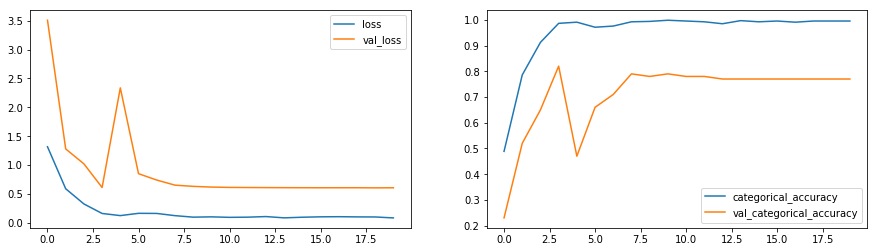

In [16]:
BATCH_SIZE = 20

train_generator, val_generator, steps_per_epoch, validation_steps = getConfig(
    TRAIN_DATA_PATH, TRAIN_DOC, VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE)

history = Conv3DModelWithFilter3_3_3_BN.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModelWithFilter3_3_3_BN'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

---
## Model: Conv3D with Filter size(2,2,2), Batch Normalization and Dropouts

In [18]:
def Conv3DWithFilter2_2_2_BN_Dropout():
    model = Sequential()
    model.add(Conv3D(32, (2, 2, 2), padding='same',
                         input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(CLASS_COUNT, activation='softmax'))

    optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model


# get model
Conv3DModelWithFilter2_2_2_BN_Dropout = Conv3DWithFilter2_2_2_BN_Dropout()

# model summary
Conv3DModelWithFilter2_2_2_BN_Dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 30, 128, 128, 32)  800       
_________________________________________________________________
activation_10 (Activation)   (None, 30, 128, 128, 32)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 128, 128, 32)  128       
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 15, 64, 64, 32)    0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 64, 64, 32)    0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 15, 64, 64, 64)    16448     
_________________________________________________________________
activation_11 (Activation)   (None, 15, 64, 64, 64)    0         
__________

Epoch 1/20
34/34 [==============================] - 59s 2s/step - loss: 1.3607 - categorical_accuracy: 0.4665 - val_loss: 1.2923 - val_categorical_accuracy: 0.5500

Epoch 00001: val_categorical_accuracy improved from -inf to 0.55000, saving model to models/Conv3DModelWithFilter2_2_2_BN_Dropout-00001-1.35983-0.46154-1.29231-0.55000.h5
Epoch 2/20
34/34 [==============================] - 54s 2s/step - loss: 0.8002 - categorical_accuracy: 0.7211 - val_loss: 1.2078 - val_categorical_accuracy: 0.5200

Epoch 00002: val_categorical_accuracy did not improve from 0.55000
Epoch 3/20
34/34 [==============================] - 54s 2s/step - loss: 0.5640 - categorical_accuracy: 0.7976 - val_loss: 1.1785 - val_categorical_accuracy: 0.6000

Epoch 00003: val_categorical_accuracy improved from 0.55000 to 0.60000, saving model to models/Conv3DModelWithFilter2_2_2_BN_Dropout-00003-0.56433-0.80090-1.17851-0.60000.h5
Epoch 4/20
34/34 [==============================] - 55s 2s/step - loss: 0.4256 - categorical_

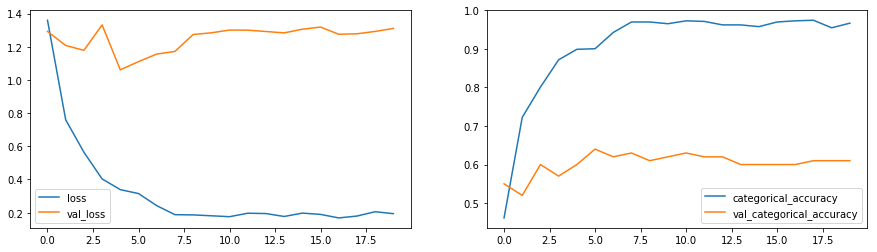

In [19]:
BATCH_SIZE = 20

train_generator, val_generator, steps_per_epoch, validation_steps = getConfig(
    TRAIN_DATA_PATH, TRAIN_DOC, VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE)

history = Conv3DModelWithFilter2_2_2_BN_Dropout.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModelWithFilter2_2_2_BN_Dropout'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

---
## Model: Conv3D with Filter size(3,3,3), Batch Normalization and Dropouts

In [20]:
def Conv3DWithFilter3_3_3_BN_Dropout():
    model = Sequential()
    model.add(Conv3D(32, (3, 3, 3), padding='same',
                         input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(CLASS_COUNT, activation='softmax'))

    optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model


# get model
Conv3DModelWithFilter3_3_3_BN_Dropout = Conv3DWithFilter3_3_3_BN_Dropout()

# model summary
Conv3DModelWithFilter3_3_3_BN_Dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 30, 128, 128, 32)  2624      
_________________________________________________________________
activation_13 (Activation)   (None, 30, 128, 128, 32)  0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 30, 128, 128, 32)  128       
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 15, 64, 64, 32)    0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 64, 64, 32)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 15, 64, 64, 64)    55360     
_________________________________________________________________
activation_14 (Activation)   (None, 15, 64, 64, 64)    0         
__________

Epoch 1/20
34/34 [==============================] - 68s 2s/step - loss: 1.4308 - categorical_accuracy: 0.4584 - val_loss: 1.1291 - val_categorical_accuracy: 0.6000

Epoch 00001: val_categorical_accuracy improved from -inf to 0.60000, saving model to models/Conv3DModelWithFilter3_3_3_BN_Dropout-00001-1.45510-0.44495-1.12910-0.60000.h5
Epoch 2/20
34/34 [==============================] - 64s 2s/step - loss: 0.7867 - categorical_accuracy: 0.6851 - val_loss: 1.5999 - val_categorical_accuracy: 0.5100

Epoch 00002: val_categorical_accuracy did not improve from 0.60000
Epoch 3/20
34/34 [==============================] - 64s 2s/step - loss: 0.6011 - categorical_accuracy: 0.7748 - val_loss: 3.5960 - val_categorical_accuracy: 0.3300

Epoch 00003: val_categorical_accuracy did not improve from 0.60000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/20
34/34 [==============================] - 64s 2s/step - loss: 0.6623 - categorical_accuracy: 0.7506 - val_lo

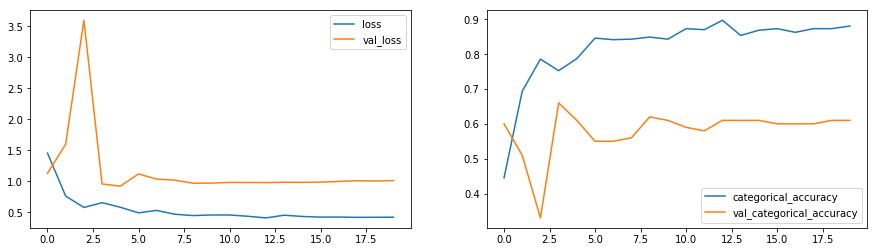

In [21]:
BATCH_SIZE = 20

train_generator, val_generator, steps_per_epoch, validation_steps = getConfig(
    TRAIN_DATA_PATH, TRAIN_DOC, VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE)

history = Conv3DModelWithFilter3_3_3_BN_Dropout.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModelWithFilter3_3_3_BN_Dropout'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

---
## Model: Conv3D with Filter size(2,2,2), Batch Normalization and More Layers

In [22]:
def Conv3DWithFilter2_2_2_BN_ExtraLayer():
    model = Sequential()
    model.add(Conv3D(32, (2, 2, 2), padding='same',
                         input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(CLASS_COUNT, activation='softmax'))

    optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model


# get model
Conv3DModelWithFilter2_2_2_BN_ExtraLayer = Conv3DWithFilter2_2_2_BN_ExtraLayer()

# model summary
Conv3DModelWithFilter2_2_2_BN_ExtraLayer.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 30, 128, 128, 32)  800       
_________________________________________________________________
activation_16 (Activation)   (None, 30, 128, 128, 32)  0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 30, 128, 128, 32)  128       
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 15, 64, 64, 32)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 15, 64, 64, 64)    16448     
_________________________________________________________________
activation_17 (Activation)   (None, 15, 64, 64, 64)    0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 15, 64, 64, 64)    256       
__________

Epoch 1/20
34/34 [==============================] - 59s 2s/step - loss: 1.5892 - categorical_accuracy: 0.3871 - val_loss: 2.3753 - val_categorical_accuracy: 0.3700

Epoch 00001: val_categorical_accuracy improved from -inf to 0.37000, saving model to models/Conv3DModelWithFilter2_2_2_BN_ExtraLayer-00001-1.59710-0.38009-2.37534-0.37000.h5
Epoch 2/20
34/34 [==============================] - 53s 2s/step - loss: 0.9877 - categorical_accuracy: 0.6181 - val_loss: 1.3381 - val_categorical_accuracy: 0.4700

Epoch 00002: val_categorical_accuracy improved from 0.37000 to 0.47000, saving model to models/Conv3DModelWithFilter2_2_2_BN_ExtraLayer-00002-0.99149-0.61689-1.33814-0.47000.h5
Epoch 3/20
34/34 [==============================] - 55s 2s/step - loss: 0.7601 - categorical_accuracy: 0.7204 - val_loss: 1.0195 - val_categorical_accuracy: 0.6500

Epoch 00003: val_categorical_accuracy improved from 0.47000 to 0.65000, saving model to models/Conv3DModelWithFilter2_2_2_BN_ExtraLayer-00003-0.77206-0.71

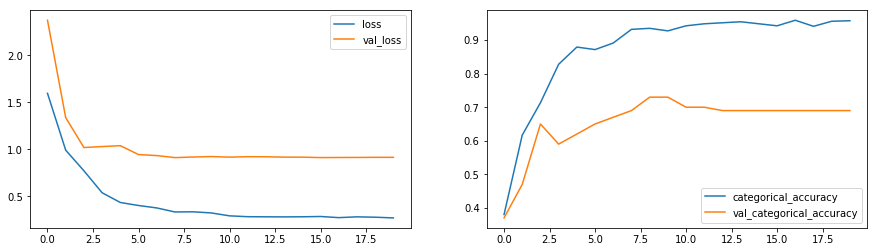

In [23]:
BATCH_SIZE = 20

train_generator, val_generator, steps_per_epoch, validation_steps = getConfig(
    TRAIN_DATA_PATH, TRAIN_DOC, VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE)

history = Conv3DModelWithFilter2_2_2_BN_ExtraLayer.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModelWithFilter2_2_2_BN_ExtraLayer'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

---
## Model: Conv3D with Filter size(3,3,3), Batch Normalization and More Layers

In [24]:
def Conv3DWithFilter3_3_3_BN_ExtraLayer():
    model = Sequential()
    model.add(Conv3D(32, (3, 3, 3), padding='same',
                         input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(128, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(CLASS_COUNT, activation='softmax'))

    optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model


# get model
Conv3DModelWithFilter3_3_3_BN_ExtraLayer = Conv3DWithFilter3_3_3_BN_ExtraLayer()

# model summary
Conv3DModelWithFilter3_3_3_BN_ExtraLayer.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 30, 128, 128, 32)  2624      
_________________________________________________________________
activation_20 (Activation)   (None, 30, 128, 128, 32)  0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 30, 128, 128, 32)  128       
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 15, 64, 64, 32)    0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 15, 64, 64, 64)    55360     
_________________________________________________________________
activation_21 (Activation)   (None, 15, 64, 64, 64)    0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 15, 64, 64, 64)    256       
__________

Epoch 1/20
34/34 [==============================] - 68s 2s/step - loss: 1.7085 - categorical_accuracy: 0.3458 - val_loss: 1.7909 - val_categorical_accuracy: 0.3900

Epoch 00001: val_categorical_accuracy improved from -inf to 0.39000, saving model to models/Conv3DModelWithFilter3_3_3_BN_ExtraLayer-00001-1.71059-0.35445-1.79094-0.39000.h5
Epoch 2/20
34/34 [==============================] - 63s 2s/step - loss: 1.0930 - categorical_accuracy: 0.5556 - val_loss: 1.6997 - val_categorical_accuracy: 0.4700

Epoch 00002: val_categorical_accuracy improved from 0.39000 to 0.47000, saving model to models/Conv3DModelWithFilter3_3_3_BN_ExtraLayer-00002-1.07837-0.56109-1.69968-0.47000.h5
Epoch 3/20
34/34 [==============================] - 63s 2s/step - loss: 0.7412 - categorical_accuracy: 0.7020 - val_loss: 2.2081 - val_categorical_accuracy: 0.3300

Epoch 00003: val_categorical_accuracy did not improve from 0.47000
Epoch 4/20
34/34 [==============================] - 63s 2s/step - loss: 0.6995 - catego

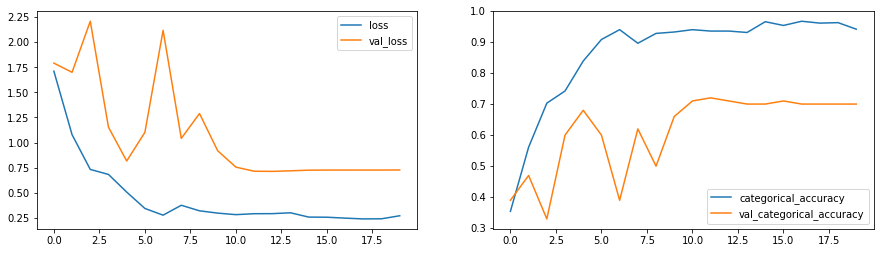

In [25]:
BATCH_SIZE = 20

train_generator, val_generator, steps_per_epoch, validation_steps = getConfig(
    TRAIN_DATA_PATH, TRAIN_DOC, VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE)

history = Conv3DModelWithFilter3_3_3_BN_ExtraLayer.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModelWithFilter3_3_3_BN_ExtraLayer'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

In [21]:
def Conv3DWithFilter3_3_3_BN_ReduceLayer():
    model = Sequential()
    model.add(Conv3D(32, (3, 3, 3), padding='same',
                         input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(CLASS_COUNT, activation='softmax'))

    optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model


# get model
Conv3DModelWithFilter3_3_3_BN_ReduceLayer = Conv3DWithFilter3_3_3_BN_ReduceLayer()

# model summary
Conv3DModelWithFilter3_3_3_BN_ReduceLayer.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 30, 128, 128, 32)  2624      
_________________________________________________________________
activation_10 (Activation)   (None, 30, 128, 128, 32)  0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 30, 128, 128, 32)  128       
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 15, 64, 64, 32)    0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 15, 64, 64, 64)    55360     
_________________________________________________________________
activation_11 (Activation)   (None, 15, 64, 64, 64)    0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 15, 64, 64, 64)    256       
__________

Epoch 1/20
34/34 [==============================] - 73s 2s/step - loss: 1.1365 - categorical_accuracy: 0.6041 - val_loss: 1.1030 - val_categorical_accuracy: 0.6200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.62000, saving model to models/Conv3DModelWithFilter3_3_3_BN_ReduceLayer-00001-1.14952-0.59427-1.10301-0.62000.h5
Epoch 2/20
34/34 [==============================] - 60s 2s/step - loss: 0.3253 - categorical_accuracy: 0.8955 - val_loss: 0.9130 - val_categorical_accuracy: 0.6700

Epoch 00002: val_categorical_accuracy improved from 0.62000 to 0.67000, saving model to models/Conv3DModelWithFilter3_3_3_BN_ReduceLayer-00002-0.31288-0.90950-0.91296-0.67000.h5
Epoch 3/20
34/34 [==============================] - 60s 2s/step - loss: 0.1708 - categorical_accuracy: 0.9691 - val_loss: 0.7965 - val_categorical_accuracy: 0.7000

Epoch 00003: val_categorical_accuracy improved from 0.67000 to 0.70000, saving model to models/Conv3DModelWithFilter3_3_3_BN_ReduceLayer-00003-0.16962-0

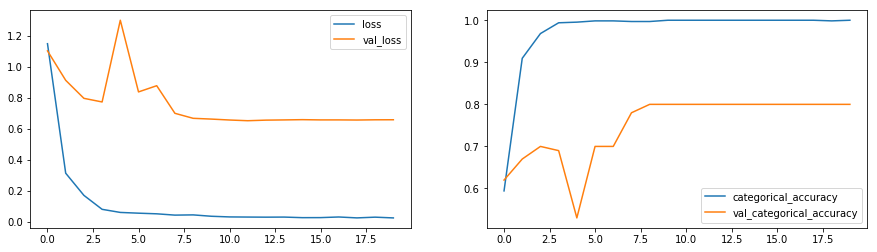

In [22]:
BATCH_SIZE = 20

train_generator, val_generator, steps_per_epoch, validation_steps = getConfig(
    TRAIN_DATA_PATH, TRAIN_DOC, VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE)

history = Conv3DModelWithFilter3_3_3_BN_ReduceLayer.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModelWithFilter3_3_3_BN_ReduceLayer'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

---
# Model: Conv3D with Filter size(3,3,3), Crop(120x120) and Batch Normalization

In [13]:
def Conv3DWithFilter3_3_3_BN_Crop():
    model = Sequential()
    model.add(Conv3D(32, (3, 3, 3), padding='same',
                         input_shape=(VIDEO_FRAME_COUNT,
                                      FRAME_RESIZE_CROP_DIMENSION[0], FRAME_RESIZE_CROP_DIMENSION[1], 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(CLASS_COUNT, activation='softmax'))

    optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model


# get model
Conv3DModelWithFilter3_3_3_BN_Crop = Conv3DWithFilter3_3_3_BN_Crop()

# model summary
Conv3DModelWithFilter3_3_3_BN_Crop.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 32)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 64)    55360     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 64)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 64)    256       
__________

Epoch 1/20
27/27 [==============================] - 169s 6s/step - loss: 1.4008 - categorical_accuracy: 0.4479 - val_loss: 1.4079 - val_categorical_accuracy: 0.4900

Epoch 00001: val_categorical_accuracy improved from -inf to 0.49000, saving model to models/Conv3DModelWithFilter3_3_3_BN_Crop-00001-1.40979-0.44495-1.40790-0.49000.h5
Epoch 2/20
27/27 [==============================] - 61s 2s/step - loss: 0.5806 - categorical_accuracy: 0.7959 - val_loss: 0.9282 - val_categorical_accuracy: 0.6400

Epoch 00002: val_categorical_accuracy improved from 0.49000 to 0.64000, saving model to models/Conv3DModelWithFilter3_3_3_BN_Crop-00002-0.58399-0.79638-0.92823-0.64000.h5
Epoch 3/20
27/27 [==============================] - 62s 2s/step - loss: 0.3395 - categorical_accuracy: 0.9206 - val_loss: 0.9819 - val_categorical_accuracy: 0.6200

Epoch 00003: val_categorical_accuracy did not improve from 0.64000
Epoch 4/20
27/27 [==============================] - 57s 2s/step - loss: 0.2357 - categorical_accur

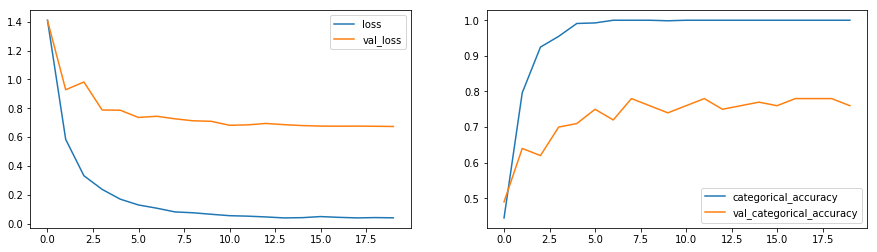

In [14]:
BATCH_SIZE = 25

train_generator, val_generator, steps_per_epoch, validation_steps = getConfig(
    TRAIN_DATA_PATH, TRAIN_DOC, VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE, crop=True)

history = Conv3DModelWithFilter3_3_3_BN_Crop.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModelWithFilter3_3_3_BN_Crop'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

---
# Model: Conv3D with Filter size(3,3,3), 15 Frames and Batch Normalization

In [15]:
def Conv3DWithFilter3_3_3_BN_15Frames():
    model = Sequential()
    model.add(Conv3D(32, (3, 3, 3), padding='same',
                         input_shape=(VIDEO_SKIP_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(CLASS_COUNT, activation='softmax'))

    optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model


# get model
Conv3DModelWithFilter3_3_3_BN_15Frames = Conv3DWithFilter3_3_3_BN_15Frames()

# model summary
Conv3DModelWithFilter3_3_3_BN_15Frames.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 15, 128, 128, 32)  2624      
_________________________________________________________________
activation_4 (Activation)    (None, 15, 128, 128, 32)  0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 128, 128, 32)  128       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 7, 64, 64, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 7, 64, 64, 64)     55360     
_________________________________________________________________
activation_5 (Activation)    (None, 7, 64, 64, 64)     0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 64, 64, 64)     256       
__________

Epoch 1/20
17/17 [==============================] - 38s 2s/step - loss: 1.6963 - categorical_accuracy: 0.3421 - val_loss: 2.1297 - val_categorical_accuracy: 0.3100

Epoch 00001: val_categorical_accuracy improved from -inf to 0.31000, saving model to models/Conv3DModelWithFilter3_3_3_BN_15Frames-00001-1.70197-0.34087-2.12970-0.31000.h5
Epoch 2/20
17/17 [==============================] - 29s 2s/step - loss: 0.9725 - categorical_accuracy: 0.6065 - val_loss: 1.3914 - val_categorical_accuracy: 0.5100

Epoch 00002: val_categorical_accuracy improved from 0.31000 to 0.51000, saving model to models/Conv3DModelWithFilter3_3_3_BN_15Frames-00002-0.96965-0.60332-1.39136-0.51000.h5
Epoch 3/20
17/17 [==============================] - 29s 2s/step - loss: 0.6753 - categorical_accuracy: 0.7464 - val_loss: 1.3703 - val_categorical_accuracy: 0.5000

Epoch 00003: val_categorical_accuracy did not improve from 0.51000
Epoch 4/20
17/17 [==============================] - 29s 2s/step - loss: 0.4580 - categorica

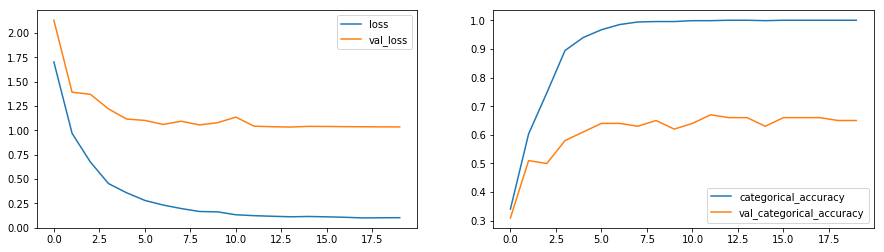

In [16]:
BATCH_SIZE = 40

train_generator, val_generator, steps_per_epoch, validation_steps = getConfig(
    TRAIN_DATA_PATH, TRAIN_DOC, VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE, skipFrames=True)

history = Conv3DModelWithFilter3_3_3_BN_15Frames.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModelWithFilter3_3_3_BN_15Frames'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

---
# Model: Conv3D with Filter size(3,3,3), Crop(120x120), 15 Frames and Batch Normalization

In [17]:
def Conv3DWithFilter3_3_3_BN_Crop_15Frames():
    model = Sequential()
    model.add(Conv3D(32, (3, 3, 3), padding='same',
                         input_shape=(VIDEO_SKIP_FRAME_COUNT, FRAME_RESIZE_CROP_DIMENSION[0], FRAME_RESIZE_CROP_DIMENSION[1], 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(CLASS_COUNT, activation='softmax'))

    optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model


# get model
Conv3DModelWithFilter3_3_3_BN_Crop_15Frames = Conv3DWithFilter3_3_3_BN_Crop_15Frames()

# model summary
Conv3DModelWithFilter3_3_3_BN_Crop_15Frames.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 15, 120, 120, 32)  2624      
_________________________________________________________________
activation_7 (Activation)    (None, 15, 120, 120, 32)  0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 15, 120, 120, 32)  128       
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 7, 60, 60, 32)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 7, 60, 60, 64)     55360     
_________________________________________________________________
activation_8 (Activation)    (None, 7, 60, 60, 64)     0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 60, 60, 64)     256       
__________

Epoch 1/20
14/14 [==============================] - 34s 2s/step - loss: 1.7293 - categorical_accuracy: 0.3487 - val_loss: 1.6880 - val_categorical_accuracy: 0.4100

Epoch 00001: val_categorical_accuracy improved from -inf to 0.41000, saving model to models/Conv3DModelWithFilter3_3_3_BN_Crop_15Frames-00001-1.76165-0.33484-1.68800-0.41000.h5
Epoch 2/20
14/14 [==============================] - 25s 2s/step - loss: 1.0052 - categorical_accuracy: 0.6016 - val_loss: 1.3848 - val_categorical_accuracy: 0.5500

Epoch 00002: val_categorical_accuracy improved from 0.41000 to 0.55000, saving model to models/Conv3DModelWithFilter3_3_3_BN_Crop_15Frames-00002-1.00205-0.60483-1.38477-0.55000.h5
Epoch 3/20
14/14 [==============================] - 25s 2s/step - loss: 0.7035 - categorical_accuracy: 0.7563 - val_loss: 1.1988 - val_categorical_accuracy: 0.5600

Epoch 00003: val_categorical_accuracy improved from 0.55000 to 0.56000, saving model to models/Conv3DModelWithFilter3_3_3_BN_Crop_15Frames-00003-0.7

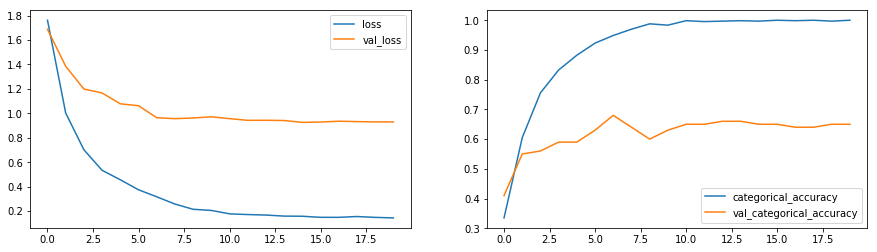

In [18]:
BATCH_SIZE = 50

train_generator, val_generator, steps_per_epoch, validation_steps = getConfig(
    TRAIN_DATA_PATH, TRAIN_DOC, VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE, crop=True, skipFrames=True)

history = Conv3DModelWithFilter3_3_3_BN_Crop_15Frames.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('Conv3DModelWithFilter3_3_3_BN_Crop_15Frames'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

---

---

# RNN Models

## GRU with MobileNet (Trainable=False)

In [19]:
def GRU_MobileNet_With_Train_False():
    mobileNetV2 = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
    
    model = Sequential()

    model.add(TimeDistributed(mobileNetV2,input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))

    model.layers[0].trainable=False

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(64))
        
    model.add(Dense(64,activation='relu'))

    model.add(Dense(CLASS_COUNT, activation='softmax'))

    optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model


GRUModel_MobileNet_With_Train_False = GRU_MobileNet_With_Train_False()

GRUModel_MobileNet_With_Train_False.summary()


9412608/9406464 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 4, 4, 1280)    5120      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 5120)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                995520    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dens

Epoch 1/20
83/83 [==============================] - 61s 735ms/step - loss: 1.6980 - categorical_accuracy: 0.2446 - val_loss: 1.8098 - val_categorical_accuracy: 0.1800

Epoch 00001: val_categorical_accuracy improved from -inf to 0.18000, saving model to models/GRUModel_MobileNet_With_Train_False-00001-1.69827-0.24434-1.80976-0.18000.h5
Epoch 2/20
83/83 [==============================] - 52s 628ms/step - loss: 1.5285 - categorical_accuracy: 0.3122 - val_loss: 1.7342 - val_categorical_accuracy: 0.1800

Epoch 00002: val_categorical_accuracy did not improve from 0.18000
Epoch 3/20
83/83 [==============================] - 53s 640ms/step - loss: 1.3434 - categorical_accuracy: 0.4555 - val_loss: 1.6804 - val_categorical_accuracy: 0.2100

Epoch 00003: val_categorical_accuracy improved from 0.18000 to 0.21000, saving model to models/GRUModel_MobileNet_With_Train_False-00003-1.34387-0.45551-1.68040-0.21000.h5
Epoch 4/20
83/83 [==============================] - 54s 648ms/step - loss: 1.1874 - cate

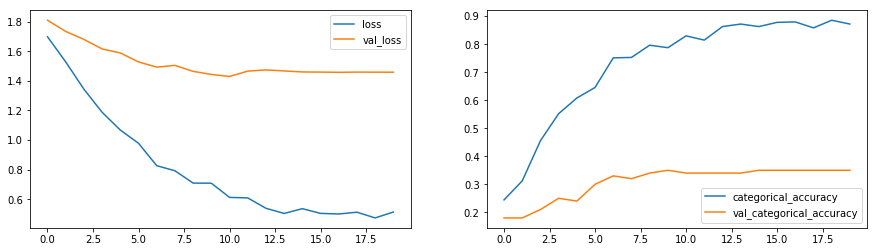

In [20]:
BATCH_SIZE = 8

train_generator, val_generator, steps_per_epoch, validation_steps = getConfig(
    TRAIN_DATA_PATH, TRAIN_DOC, VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE)

history = GRUModel_MobileNet_With_Train_False.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('GRUModel_MobileNet_With_Train_False'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

## GRU with MobileNet (Trainable=True)

In [25]:
def GRU_MobileNet_With_Train_True():
    mobileNetV2 = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
    
    model = Sequential()

    model.add(TimeDistributed(mobileNetV2,input_shape=(VIDEO_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(64))
            
    model.add(Dense(64,activation='relu'))

    model.add(Dense(CLASS_COUNT, activation='softmax'))

    optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model


GRUModel_MobileNet_With_Train_True = GRU_MobileNet_With_Train_True()

GRUModel_MobileNet_With_Train_True.summary()


9412608/9406464 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 4, 4, 1280)    5120      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 5120)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                995520    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Den

Epoch 1/20
83/83 [==============================] - 114s 1s/step - loss: 1.6004 - categorical_accuracy: 0.2491 - val_loss: 1.5291 - val_categorical_accuracy: 0.3000

Epoch 00001: val_categorical_accuracy improved from -inf to 0.30000, saving model to models/GRUModel_MobileNet_With_Train_True-00001-1.60053-0.24887-1.52911-0.30000.h5
Epoch 2/20
83/83 [==============================] - 97s 1s/step - loss: 1.2220 - categorical_accuracy: 0.5488 - val_loss: 1.3439 - val_categorical_accuracy: 0.4500

Epoch 00002: val_categorical_accuracy improved from 0.30000 to 0.45000, saving model to models/GRUModel_MobileNet_With_Train_True-00002-1.22194-0.54902-1.34388-0.45000.h5
Epoch 3/20
83/83 [==============================] - 97s 1s/step - loss: 1.0188 - categorical_accuracy: 0.6895 - val_loss: 1.0915 - val_categorical_accuracy: 0.5900

Epoch 00003: val_categorical_accuracy improved from 0.45000 to 0.59000, saving model to models/GRUModel_MobileNet_With_Train_True-00003-1.01941-0.68929-1.09151-0.590

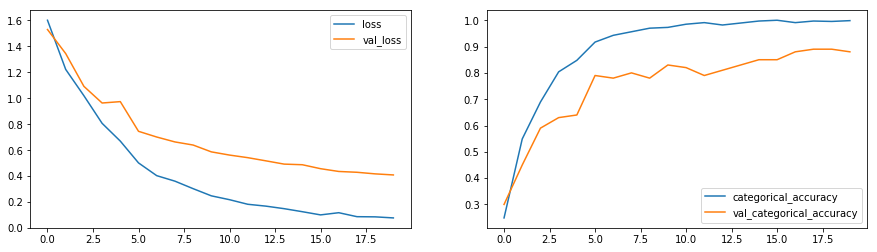

In [26]:
BATCH_SIZE = 8

train_generator, val_generator, steps_per_epoch, validation_steps = getConfig(
    TRAIN_DATA_PATH, TRAIN_DOC, VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE)


history = GRUModel_MobileNet_With_Train_True.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('GRUModel_MobileNet_With_Train_True'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

## GRU with MobileNet (Trainable=True) and 15 Frames

In [13]:
def GRU_MobileNet_With_Train_True_and_15_Frames():
    mobileNetV2 = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
    
    model = Sequential()

    model.add(TimeDistributed(mobileNetV2,input_shape=(VIDEO_SKIP_FRAME_COUNT, FRAME_RESIZE_DIMENSION[0], FRAME_RESIZE_DIMENSION[1], 3)))

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(64))
            
    model.add(Dense(128,activation='relu'))

    model.add(Dense(CLASS_COUNT, activation='softmax'))

    optimiser = optimizers.SGD(lr=0.001, decay=1e-6, nesterov=True)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model


GRUModel_MobileNet_With_Train_True_and_15_Frames = GRU_MobileNet_With_Train_True_and_15_Frames()

GRUModel_MobileNet_With_Train_True_and_15_Frames.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 4, 4, 1280)    5120      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 5120)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                995520    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total para

Epoch 1/20
45/45 [==============================] - 63s 1s/step - loss: 1.6755 - categorical_accuracy: 0.2238 - val_loss: 1.6027 - val_categorical_accuracy: 0.2700

Epoch 00001: val_categorical_accuracy improved from -inf to 0.27000, saving model to models/GRUModel_MobileNet_With_Train_True_and_15_Frames-00001-1.67217-0.22775-1.60269-0.27000.h5
Epoch 2/20
45/45 [==============================] - 48s 1s/step - loss: 1.4859 - categorical_accuracy: 0.3614 - val_loss: 1.5708 - val_categorical_accuracy: 0.3300

Epoch 00002: val_categorical_accuracy improved from 0.27000 to 0.33000, saving model to models/GRUModel_MobileNet_With_Train_True_and_15_Frames-00002-1.48696-0.35596-1.57079-0.33000.h5
Epoch 3/20
45/45 [==============================] - 48s 1s/step - loss: 1.3281 - categorical_accuracy: 0.5127 - val_loss: 1.4603 - val_categorical_accuracy: 0.4200

Epoch 00003: val_categorical_accuracy improved from 0.33000 to 0.42000, saving model to models/GRUModel_MobileNet_With_Train_True_and_15_F

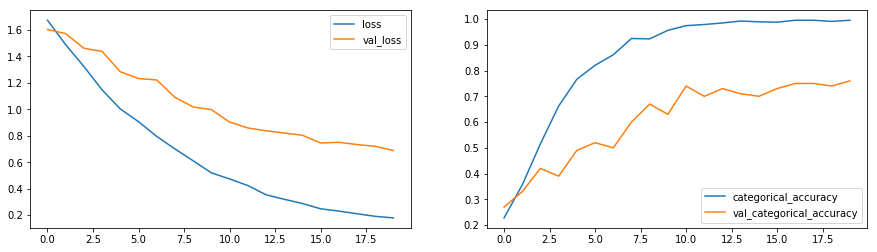

In [14]:
BATCH_SIZE = 15

train_generator, val_generator, steps_per_epoch, validation_steps = getConfig(
    TRAIN_DATA_PATH, TRAIN_DOC, VALIDATION_DATA_PATH, VALIDATION_DOC, BATCH_SIZE, skipFrames=True)


history = GRUModel_MobileNet_With_Train_True_and_15_Frames.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1,
    callbacks=model_callbacks('GRUModel_MobileNet_With_Train_True_and_15_Frames'),
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0)

plot(history)

In [ ]:
# Epoch 00019: val_categorical_accuracy improved from 0.78000 to 0.79000, saving model to temporary/model-00019-0.14550-0.99548-0.60817-0.79000.h5
    